In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from aequitas.group import Group
import joblib
from pycaret.classification import save_model, create_model
from pycaret.classification import load_model


<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Note:</span></b> 

- You will find paths of my device. Please change it to yours.

Example: <span style='color:red'>/Users/gavesh_aggarwal/Desktop</span>/Mule_Account_Detection/32 Column Dataset/archive/Base.csv

- Run the cells based on your requirements. Check out GitHub Readme for details.

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Training:</span></b> 0-5 months

The dataset has a column 'month'. Each account number has a month assigned to it: [0,7]. 

I took the account numbers with the months 0-5 for training and the account numbers with the months 6-7 for testing.

In [2]:
# Load the dataset
df = pd.read_csv('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/Base_less_cols.csv')

# Display the first few rows of the dataset and inspect columns
print("Shape of the dataset:", df.shape)
df.head()


Shape of the dataset: (1000000, 24)


,Account_Number,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month
0,1,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,...,5,5,CB,163,1,0,16.224843,1,1,0
1,2,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,...,3,18,CA,154,1,0,3.363854,1,1,0
2,3,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,...,15,11,CA,89,1,0,22.730559,0,1,0
3,4,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,...,11,13,CA,90,1,0,15.215816,1,1,0
4,5,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,...,1,6,CA,91,0,0,3.743048,0,1,0


In [3]:
# Remove unnecessary column 'device_fraud_count'
df = df.drop(['device_fraud_count'], axis=1, errors='ignore')

# Count the number of non-frauds and frauds
fraud_counts = df['fraud_bool'].value_counts()
print("Fraud counts:\n", fraud_counts)

# Split data into features and target
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

# Train test split by 'month': months 0-5 are train, 6-7 are test data
X_train = X[X['month'] < 6].copy()
X_test = X[X['month'] >= 6].copy()
y_train = y[X['month'] < 6].copy()
y_test = y[X['month'] >= 6].copy()

# Drop 'month' column from train and test sets
X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

# Display shapes of train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Fraud counts:
 fraud_bool
0    988971
1     11029
Name: count, dtype: int64
Shape of X_train: (794989, 22)
Shape of X_test: (205011, 22)


In [4]:
# Identify categorical columns
object_cols = X_train.select_dtypes(include='object').columns

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# One-hot encode categorical columns
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]), index=X_train.index)
ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]), index=X_test.index)

# Drop original categorical columns from train and test sets
X_train = pd.concat([X_train.drop(object_cols, axis=1), ohe_cols_train], axis=1)
X_test = pd.concat([X_test.drop(object_cols, axis=1), ohe_cols_test], axis=1)

# Ensure all column names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Display first row of transformed data
X_train.head(1)


,Account_Number,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,2,3,4,5,6,7,8,9,10,11
0,1,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.03502,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Initialize StandardScaler
scaler = StandardScaler()

# Scale numerical features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display scaled data
X_train[:1]


array([[-1.73204863, -0.84791304,  1.67617685, -0.39549725, -0.70201773,
         0.5239276 , -0.19688014,  4.5784764 , -0.60087354,  2.30536194,
         2.01256248,  2.14674366, -0.39856874, -0.96709549,  0.50301888,
         0.91934443, -0.16335588,  1.03915893,  0.87017251, -0.10906927,
         1.67488258, -0.7540708 , -0.57702443, -0.37728253, -0.01766498,
        -1.59933029,  2.42610853, -0.2022697 , -0.16872344, -0.15282242,
        -0.21851234, -0.02163678]])

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Logistic Regression</span></b>

Logistic Regression AUC: 0.8063907804776994


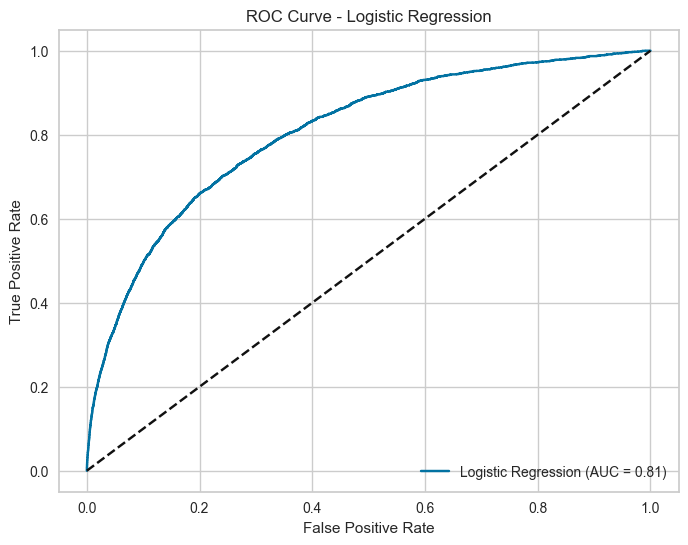

['/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/lr_model.joblib']

In [6]:
# Train Logistic Regression model
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, y_train)

# Predict probabilities for test set
lr_predictions = lr_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
lr_auc = roc_auc_score(y_test, lr_predictions)
print("Logistic Regression AUC:", lr_auc)

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(lr_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(lr_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/lr_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>XGBoost</span></b>

XGBoost AUC: 0.788799532554452


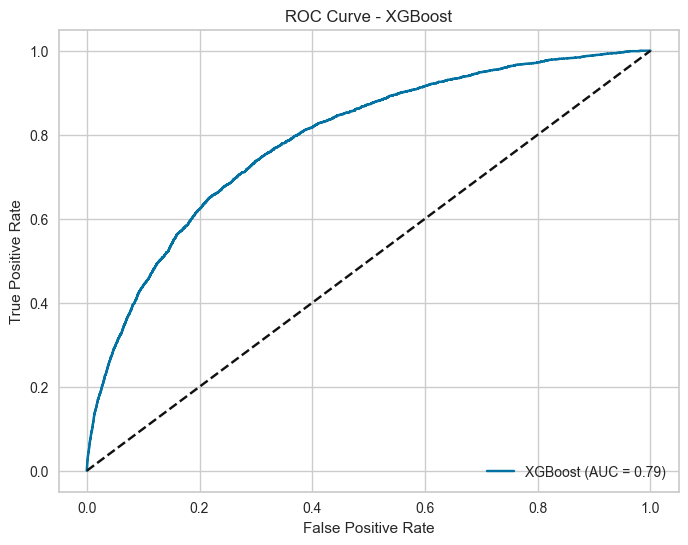

['/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/xgb_model.joblib']

In [7]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(tree_method='hist', scale_pos_weight=89.67005)
xgb_model.fit(X_train, y_train)

# Predict probabilities for test set
xgb_predictions = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
xgb_auc = roc_auc_score(y_test, xgb_predictions)
print("XGBoost AUC:", xgb_auc)

# Plot ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(xgb_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(xgb_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/xgb_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Random Forest</span></b>

Random Forest AUC: 0.6940041923353041


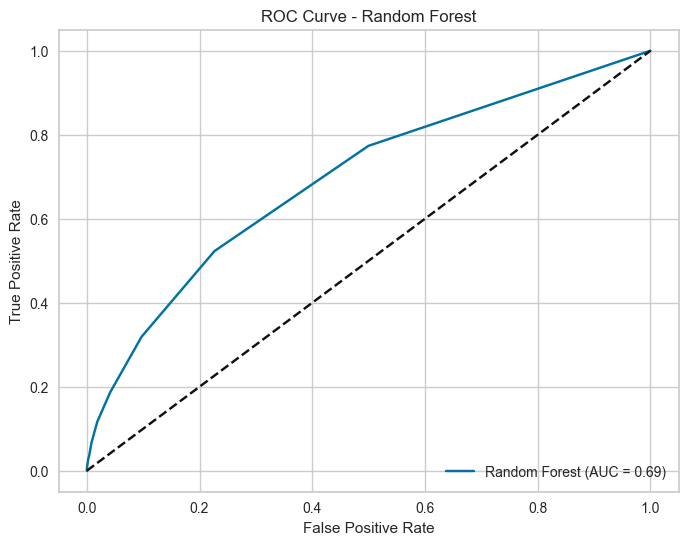

['/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/rf_model.joblib']

In [8]:
# Train Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predict probabilities for test set
rf_predictions = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
rf_auc = roc_auc_score(y_test, rf_predictions)
print("Random Forest AUC:", rf_auc)

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(rf_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(rf_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/rf_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Note:</span></b> 
After you have trained and saved the models once, you can load them from next time.

In [6]:
# Loading

# BASE_LESS_COLS
lr_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/lr_model.joblib')
xgb_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/xgb_model.joblib')
rf_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/3. MODELS_BASE_LESS_0-5_MONTHS/rf_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Testing:</span></b> 6-7 months

<a id="3.3"></a>
## <b><span style='color:yellow'>Approach:</span></b> 

- Finding fraud accounts using the average of all models.

In [7]:
# Predictions

lr_predictions = lr_model.predict_proba(X_test)[:, 1]
xgb_predictions = xgb_model.predict_proba(X_test)[:, 1]
rf_predictions = rf_model.predict_proba(X_test)[:, 1]

In [58]:
# Combine predictions from all models
predictions = (lr_predictions + xgb_predictions + rf_predictions)/3
#print(predictions)

# Create DataFrame for test set with predictions
test_df = df[df["month"] >= 6].copy()
test_df['predicted_fraud'] = predictions

# Identify fraudulent accounts (threshold > 0.5)
fraudulent_accounts = test_df[test_df['predicted_fraud'] > 0.53]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(test_df)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)
print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))


Number of Fraudulent Accounts: 2706
Percentage of Fraudulent Accounts: 1.32%


<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Loading the actual given fraudulent accounts</span></b> 

In [27]:
# Actual Fraud Accounts

import pandas as pd

# Load the CSV file
df = pd.read_csv('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/Base_less_cols.csv')  # Update the path to your base.csv

# Filter the rows where fraud_bool is 1
fraud_accounts = df[df['fraud_bool'] == 1]

# Get the unique account numbers with fraud_bool=1
unique_fraud_accounts = fraud_accounts['Account_Number'].unique()

# Define the output file path
output_file_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/actual_fraudulent_accounts.txt'

# Save the unique account numbers to the text file
with open(output_file_path, 'w') as f:
    for account_number in unique_fraud_accounts:
        f.write(f"{account_number}\n")

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Comparing my fraudulent accounts and actual fraudulent accounts.</span></b> 

In [60]:
# PERCENTAGE ACCURACY IN MY MODEL

# File paths
file1_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/fraudulent_accounts.txt'
file2_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/actual_fraudulent_accounts.txt'

# Load numbers from both files
with open(file1_path, 'r') as file1:
    numbers1 = set(map(int, file1.readlines()))

with open(file2_path, 'r') as file2:
    numbers2 = set(map(int, file2.readlines()))

# Find common numbers
common_numbers = numbers1.intersection(numbers2)

# Number of common numbers
num_common = len(common_numbers)

# Total numbers in fraudulent_accounts.txt
total_numbers_in_file1 = len(numbers1)

# Percentage of common numbers
percentage_common = (num_common / total_numbers_in_file1) * 100

percentage_common

14.227642276422763